In [112]:
import boto3
import os
import logging
import time
import pandas as pd
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

## Landing to S3

In [113]:
s3_client = boto3.client('s3', aws_access_key_id='***********', aws_secret_access_key='************')
s3_bucket_name = 'loan-test001'
s3_path = "loan-data/dump"
local_directory = './inbox/loan-data'
local_archived_directory = './archive/loan-data'


def fn_load_to_s3():
    # fetch the list of csv files in the path
    csv_files = [f for f in os.listdir(local_directory) if f.endswith('.csv')]

    if csv_files:
        s3_obj_key_list = []
        for file_name in csv_files:
            upload_flag = 0

            # Appending filename with timestamp to avoid file name conflict in S3
            file_name_s3 = f"{file_name.split('.csv')[0]}_{str(int(round(time.time())))}.csv"
            # s3 object key
            s3_object_key = f'{s3_path}/{file_name_s3}'

            # Read the CSV to a DataFrame
            df = pd.read_csv(os.path.join(local_directory, file_name))

            # Upload the DataFrame as a CSV file to S3
            try:
                s3_client.put_object(
                    Bucket=s3_bucket_name,
                    Key=s3_object_key,
                    Body=df.to_csv(index=False, header=False),
                )
                upload_flag = 1
            except Exception as e:
                raise Exception(f"S3 upload error. {e}")

            if upload_flag == 1:
                logging.info(f'Uploaded {file_name_s3} to S3')
                s3_obj_key_list.append(file_name_s3)
                # Archive the local file
                os.rename(f"{local_directory}/{file_name}", f"{local_archived_directory}/{file_name}")

    else:
        logging.info("No new files..")

    logging.info("fn_load_to_s3 completed")

In [114]:
fn_load_to_s3()

## Writing to SnowFlake Core

In [120]:
sf_username = '********'
sf_password = '********'
sf_account = '*********'
sf_warehouse = 'COMPUTE_WH'
sf_database = 'TESTDB'
sf_schema = 'CORE'
sf_table = 'tbl_loan_application'
s3_stage_name = "stg_s3_loan_application"

dbcon = snowflake.connector.connect(
    user=sf_username,
    password=sf_password,
    account=sf_account,
    warehouse=sf_warehouse,
    database=sf_database,
    schema=sf_schema
)

In [116]:
def fn_load_s3_to_sf():
    try:
        cursor = dbcon.cursor()
        cursor.execute(f"""
            COPY INTO {sf_schema}.{sf_table}(_index,serious_dlq_in_2yrs,revolving_util_of_unsecured_lines,age,
            num_of_time_30_59_days_past_due_not_worse,debt_ratio,monthly_income,num_of_open_cred_ln_n_loans,
            num_of_times_90days_late,num_real_estate_loans_or_lines,num_of_time_60_89_day_past_due_nt_worse,
            number_of_dependents,_file_name,_load_ts)
            FROM (select trim(hdr.$1),trim(hdr.$2), trim(hdr.$3), trim(hdr.$4), trim(hdr.$5), trim(hdr.$6),trim(hdr.$7),
            trim(hdr.$8), trim(hdr.$9), trim(hdr.$10), trim(hdr.$11), trim(hdr.$12),
            METADATA$FILENAME,current_timestamp(0) from @{s3_stage_name} hdr)
            FILE_FORMAT = (TYPE = 'CSV');"""
            )
        logging.info(f"Successfully loaded data")
    except Exception as e:
        raise Exception(f"File to DB load error. {e}")
    finally:
        cursor.close()

    logging.info("fn_load_s3_to_sf completed")
    dbcon.close()

In [117]:
fn_load_s3_to_sf()

## Cleaning up and preparing for analysis (Semantic)

In [118]:
def fn_remove_outliers(df, column_name, threshold=3):
    z_scores = np.abs(stats.zscore(df[column_name]))
    df_no_outliers = df[np.abs(z_scores) <= threshold]
    return df_no_outliers


def fn_process_semantic():
    logging.info("starting fn_process_semantic")
    # Fetching incremental data to pandas df
    data = pd.read_sql(f"""
    select * from TESTDB.CORE.vw_loan_application
    where _load_ts > (select coalesce(max(_load_ts),'2000-01-01 00:00:00') from TESTDB.SEMANTIC.tbl_loan_application);
    """, dbcon)
    if not data.empty:
        # Removing duplicates
        data = data.drop_duplicates()
        # Removing outliers
        data = fn_remove_outliers(data, 'DEBT_RATIO')
        data = fn_remove_outliers(data, 'REVOLVING_UTIL_OF_UNSECURED_LINES')
        display(data)

        # Loading back to the database
        success, nchunks, nrows, _ = write_pandas(conn=dbcon,
                                                  df=data,
                                                  table_name='TBL_LOAN_APPLICATION',
                                                  database='TESTDB',
                                                  schema='SEMANTIC')
        print(f"""
        Success: {success}
        Chunks: {nchunks}
        Rows: {nrows}
        """)
    logging.info("fn_process_semantic completed.")

In [121]:
fn_process_semantic()

,_INDEX,SERIOUS_DLQ_IN_2YRS,REVOLVING_UTIL_OF_UNSECURED_LINES,AGE,NUM_OF_TIME_30_59_DAYS_PAST_DUE_NOT_WORSE,DEBT_RATIO,MONTHLY_INCOME,NUM_OF_OPEN_CRED_LN_N_LOANS,NUM_OF_TIMES_90DAYS_LATE,NUM_REAL_ESTATE_LOANS_OR_LINES,NUM_OF_TIME_60_89_DAY_PAST_DUE_NT_WORSE,NUMBER_OF_DEPENDENTS,_FILE_NAME,_LOAD_TS
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,loan-data/dump/sample_data_1695451897.csv,2023-09-22 23:52:43
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,loan-data/dump/sample_data_1695451897.csv,2023-09-22 23:52:43
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,loan-data/dump/sample_data_1695451897.csv,2023-09-22 23:52:43
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,loan-data/dump/sample_data_1695451897.csv,2023-09-22 23:52:43
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,loan-data/dump/sample_data_1695451897.csv,2023-09-22 23:52:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0,loan-data/dump/sample_data_1695451897.csv,2023-09-22 23:52:43
149996,149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0,loan-data/dump/sample_data_1695451897.csv,2023-09-22 23:52:43
149997,149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0,loan-data/dump/sample_data_1695451897.csv,2023-09-22 23:52:43
149998,149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0,loan-data/dump/sample_data_1695451897.csv,2023-09-22 23:52:43


/opt/anaconda3/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(



        Success: True
        Chunks: 1
        Rows: 149152
        


## Insights

In [ ]:
data=pd.read_sql(f"""select * from TESTDB.SEMANTIC.loan_application_agg""", dbcon)
display(data)

### Age vs Debt Ratio and LifeStyle Expense relation

,AGE_GROUP,Avg. Debt Ratio,Avg. Lifestyle Cost Ratio
0,20s,0.368832,0.592281
1,30s,0.456712,0.555052
2,40s,0.481837,0.476965
3,50s,0.478770,0.467939
4,60s,0.489228,0.378187
5,Senior Citizen,0.467702,0.296765


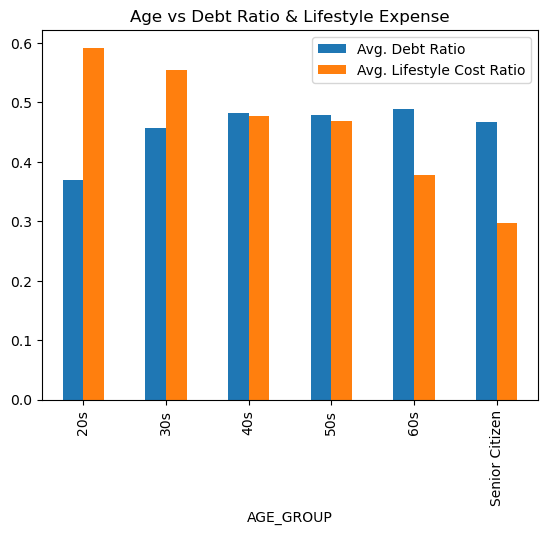

In [100]:
data = pd.read_sql("""select AGE_GROUP,avg(AVG_DEBT_RATIO) as "Avg. Debt Ratio",
avg(AVG_REVOLVING_UTIL_OF_UNSECURED_LINES) as "Avg. Lifestyle Cost Ratio"
from TESTDB.SEMANTIC.loan_application_agg where age_group<>'Unknown'
                   group by 1 order by 1""",dbcon)
display(data)
data.plot(x='AGE_GROUP',y=['Avg. Debt Ratio','Avg. Lifestyle Cost Ratio'],kind='bar',title='Age vs Debt Ratio & Lifestyle Expense')
#data.plot(x='AGE_GROUP',y='AVG_REVOLVING_UTIL_OF_UNSECURED_LINES',kind='bar',title='Age vs Lifestyle')


plt.show()

In [ ]:
data = pd.read_sql("""select AGE_GROUP,avg(AVG_DEBT_RATIO) as AVG_DEBT_RATIO,
avg(AVG_REVOLVING_UTIL_OF_UNSECURED_LINES) as AVG_REVOLVING_UTIL_OF_UNSECURED_LINES
from TESTDB.SEMANTIC.loan_application_agg where age_group<>'Unknown'
                   group by 1 order by 1""",dbcon)
display(data)
data.plot(x='AGE_GROUP',y=['AVG_DEBT_RATIO','AVG_REVOLVING_UTIL_OF_UNSECURED_LINES'],kind='bar',title='Age vs Debt Ratio')
#data.plot(x='AGE_GROUP',y='AVG_REVOLVING_UTIL_OF_UNSECURED_LINES',kind='bar',title='Age vs Lifestyle')


plt.show()

In [122]:
data = pd.read_sql("select * from TESTDB.SEMANTIC.loan_application_agg",dbcon)
data.to_csv('/Users/Subhajit/Documents/AWS/Juyter-Notebooks/loan_application_agg.csv',index=False)